In [62]:
import pandas as pd
import numpy as np
import networkx as nx 
import plotly.graph_objects as go 
import plotly.express as px
import seaborn as sns

# Loading Data

**Loading Network Data**

In [13]:
net_path = r"../../data/processed_io_data/network_metrics.csv"
pnw_path = r"../../data/processed_io_data/production_network_edges.csv"

In [14]:
netmetrics_df = pd.read_csv(net_path)
pnw_df = pd.read_csv(pnw_path)

**Network Data Preview**

In [15]:
# First Network Data
netmetrics_df.head()

,sector_id,sector_name,backward_linkage,forward_linkage,is_key_sector,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,1,Paddy,2.056934,1.990450,False,0.238462,0.002546,0.449332,0.043067,0.005365
1,2,Wheat,1.507685,1.354732,False,0.269231,0.002786,0.447604,0.037984,0.004517
2,3,Jowar,2.208182,1.072066,False,0.123077,0.000121,0.421656,0.025812,0.002765
3,4,Bajra,1.296106,1.095623,False,0.115385,0.000139,0.414153,0.021663,0.002513
4,5,Maize,1.598353,1.091067,False,0.130769,0.000153,0.421656,0.025812,0.002623


In [16]:
netmetrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sector_id               131 non-null    int64  
 1   sector_name             131 non-null    object 
 2   backward_linkage        131 non-null    float64
 3   forward_linkage         131 non-null    float64
 4   is_key_sector           131 non-null    bool   
 5   degree_centrality       131 non-null    float64
 6   betweenness_centrality  131 non-null    float64
 7   closeness_centrality    131 non-null    float64
 8   eigenvector_centrality  131 non-null    float64
 9   pagerank                131 non-null    float64
dtypes: bool(1), float64(7), int64(1), object(1)
memory usage: 9.5+ KB


**Network Edge Data Preview**

In [17]:
# Preview the Production Network Edge Data
pnw_df.head()

,source_sector,target_sector,input_coefficient,input_value
0,Paddy,Paddy,0.045751,1043496.0
1,Paddy,Gram,0.005281,17773.0
2,Paddy,Pulses,0.008829,54046.0
3,Paddy,Other crops,0.007219,264143.0
4,Paddy,Poultry & Eggs,0.082899,857493.0


In [20]:
pnw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401 entries, 0 to 3400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source_sector      3401 non-null   object 
 1   target_sector      3401 non-null   object 
 2   input_coefficient  3401 non-null   float64
 3   input_value        3401 non-null   float64
dtypes: float64(2), object(2)
memory usage: 106.4+ KB


In [ ]:
# Checking which sectors match between nodes and edges

# Inspecting Network Structure

In [29]:
# How Connected is the Network?
total_nodes = len(netmetrics_df)
print(f"Total Nodes (Sectors): {total_nodes}")

# Count the total edges 
total_edges = len(pnw_df)
print(f"Total Edges (Connections): {total_edges:,}")

# Calculate Network Density
possible_edges = total_nodes *(total_nodes-1)
density = total_edges/possible_edges
print(f"\nPossible Edges: {possible_edges:,}")
print(f"Network Density: {density:.4f} ({density*100:.2f}%)")

Total Nodes (Sectors): 131
Total Edges (Connections): 3,401

Possible Edges: 17,030
Network Density: 0.1997 (19.97%)


In [36]:
# Check for isolated nodes:
# Get all unique sectors
sectors_in_edges = pd.concat([
    pnw_df['source_sector'], 
    pnw_df['target_sector']
]).unique()

# Compare with all sectors in network_metrics
all_sectors = netmetrics_df['sector_name'].values
isolated_sectors = set(all_sectors) - set(sectors_in_edges)
print(f"\nSectors in edges: {len(sectors_in_edges)}")
print(f"Isolated sectors (no connections): {len(isolated_sectors)}")

if len(isolated_sectors) > 0:
    print(f"\nIsolated sectors:")
    for sector in isolated_sectors:
        print(f"  - {sector}")


Sectors in edges: 131
Isolated sectors (no connections): 0


# Analyze Degree Distribution

In [38]:
in_degree = pnw_df['target_sector'].value_counts()
out_degree = pnw_df['source_sector'].value_counts()

print(f"\n{'='*70}")
print("DEGREE STATISTICS:")
print(f"{'='*70}")
print(f"\nIn-Degree (Number of Suppliers per Sector):")
print(f"  Mean: {in_degree.mean():.1f}")
print(f"  Median: {in_degree.median():.1f}")
print(f"  Min: {in_degree.min()}")
print(f"  Max: {in_degree.max()}")

print(f"\nOut-Degree (Number of Customers per Sector):")
print(f"  Mean: {out_degree.mean():.1f}")
print(f"  Median: {out_degree.median():.1f}")
print(f"  Min: {out_degree.min()}")
print(f"  Max: {out_degree.max()}")


DEGREE STATISTICS:

In-Degree (Number of Suppliers per Sector):
  Mean: 26.0
  Median: 24.0
  Min: 2
  Max: 58

Out-Degree (Number of Customers per Sector):
  Mean: 26.6
  Median: 16.0
  Min: 1
  Max: 129


# Most Connected Sectors

In [39]:
# Find sectors with highest total degree (in + out)
total_degree = (
    in_degree.to_frame("in_degree")
    .join(out_degree.to_frame("out_degree"), how='outer')
    .fillna(0)
)
total_degree['total_degree'] = total_degree['in_degree'] + total_degree['out_degree']

print("TOP 10 MOST CONNECTED SECTORS")
total_degree.head(10)

TOP 10 MOST CONNECTED SECTORS


,in_degree,out_degree,total_degree
Air transport,20,66.0,86.0
Aircraft & spacecraft,17,2.0,19.0
Animal Services,12,17.0,29.0
"Art silk, synthetic fiber\n textiles",27,22.0,49.0
Bajra,10,5.0,15.0
Batteries,36,16.0,52.0
Bauxite,23,7.0,30.0
Beverages,36,3.0,39.0
"Bicycles, cycle-rickshaw",35,1.0,36.0
Carpet weaving,31,1.0,32.0


# Summary Statistics Display: 

In [40]:
# Create a summary DataFrame for easy viewing
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Nodes (Sectors)',
        'Total Edges (Connections)',
        'Possible Edges',
        'Network Density',
        'Isolated Nodes',
        'Avg In-Degree',
        'Avg Out-Degree'
    ],
    'Value': [
        total_nodes,
        f"{total_edges:,}",
        f"{possible_edges:,}",
        f"{density*100:.2f}%",
        len(isolated_sectors),
        f"{in_degree.mean():.1f}",
        f"{out_degree.mean():.1f}"
    ]
})


print("NETWORK STRUCTURE SUMMARY:")
display(summary_stats)

NETWORK STRUCTURE SUMMARY:


,Metric,Value
0,Total Nodes (Sectors),131
1,Total Edges (Connections),"3,401"
2,Possible Edges,"17,030"
3,Network Density,19.97%
4,Isolated Nodes,0
5,Avg In-Degree,26.0
6,Avg Out-Degree,26.6


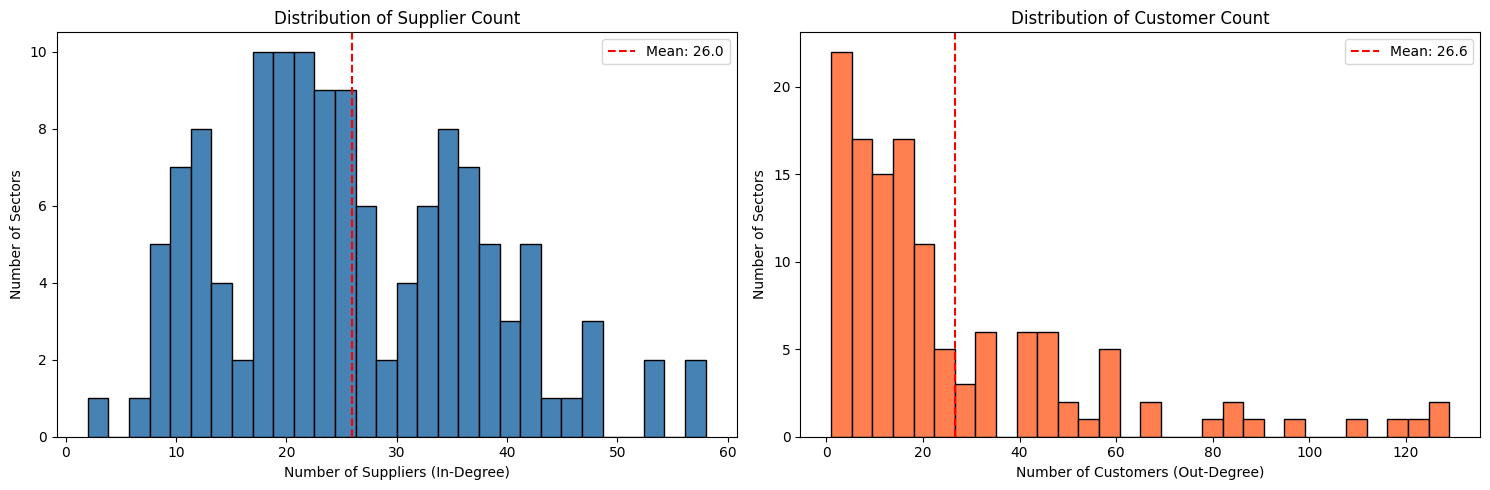

In [41]:
# Create a simple histogram of degree distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# In-degree distribution
axes[0].hist(in_degree.values, bins=30, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Number of Suppliers (In-Degree)')
axes[0].set_ylabel('Number of Sectors')
axes[0].set_title('Distribution of Supplier Count')
axes[0].axvline(in_degree.mean(), color='red', linestyle='--', label=f'Mean: {in_degree.mean():.1f}')
axes[0].legend()

# Out-degree distribution
axes[1].hist(out_degree.values, bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Number of Customers (Out-Degree)')
axes[1].set_ylabel('Number of Sectors')
axes[1].set_title('Distribution of Customer Count')
axes[1].axvline(out_degree.mean(), color='red', linestyle='--', label=f'Mean: {out_degree.mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Visualizations

## Bottleneck Analysis

In [52]:
# Prepare data for bottleneck analysis
bottleneck_data = netmetrics_df.copy()
# Calculate number of dependent downstream sectors (out-degree from edges)
downstream_count = pnw_df['source_sector'].value_counts()
bottleneck_data = bottleneck_data.merge(
    downstream_count.to_frame('downstream_sectors'),
    left_on='sector_name',
    right_index=True,
    how='left'
)
bottleneck_data['downstream_sectors'] = bottleneck_data['downstream_sectors'].fillna(0)

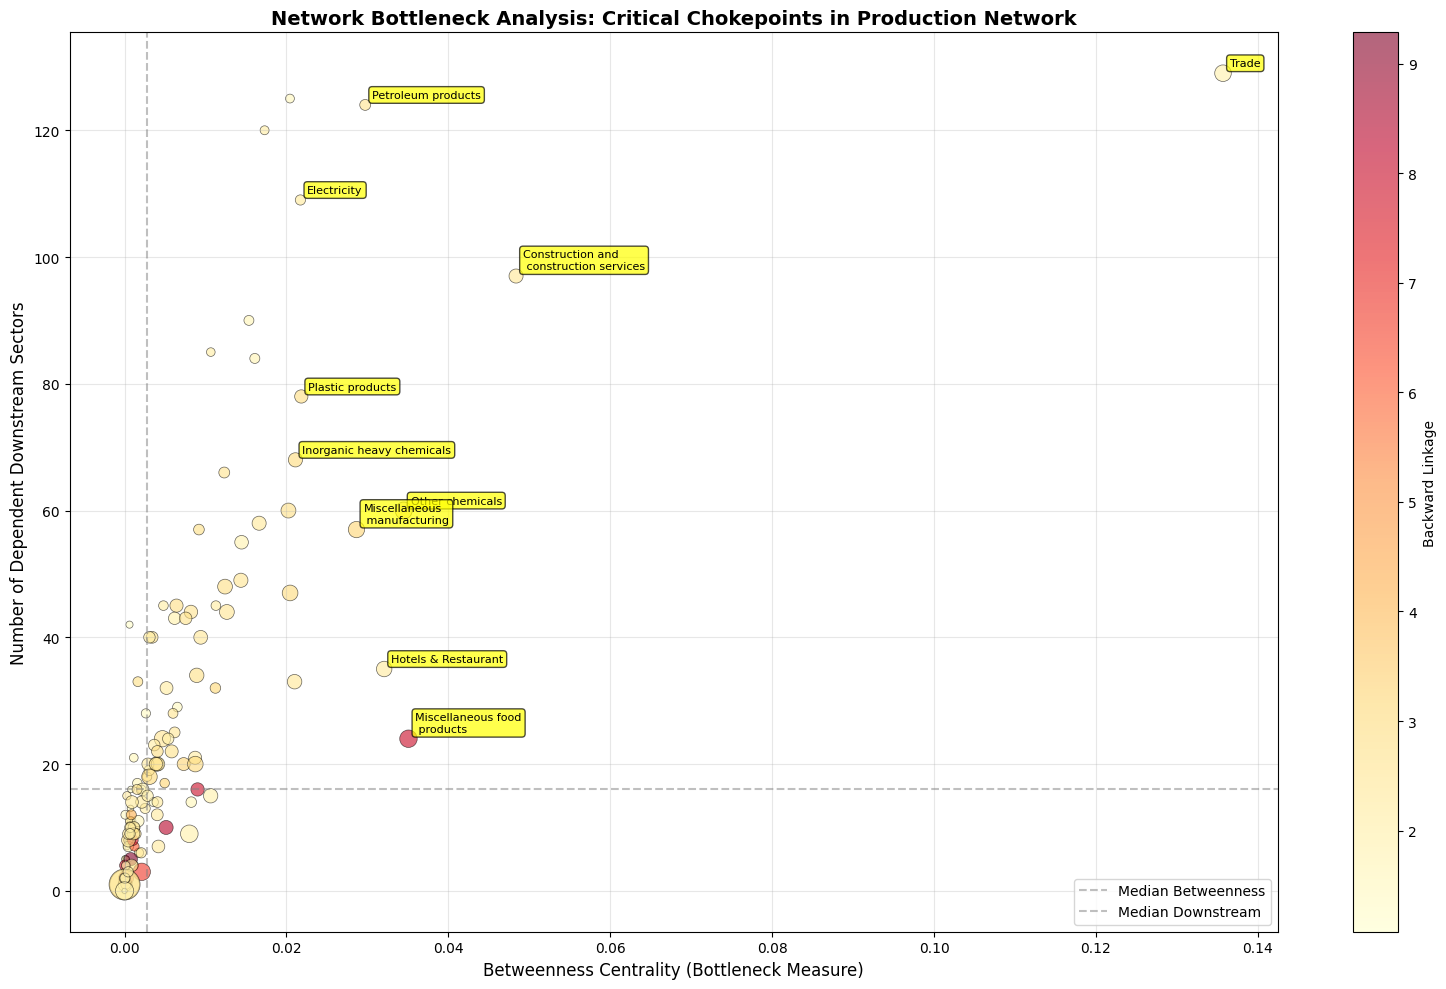

Critical Bottleneck Sectors (High Betweenness + Many Dependencies):


,sector_name,betweenness_centrality,downstream_sectors,pagerank
116,Trade,0.135703,129.0,0.014298
106,Construction and\n construction services,0.048364,97.0,0.010264
42,Miscellaneous food\n products,0.035073,24.0,0.015866
72,Other chemicals,0.034482,60.0,0.015045
117,Hotels & Restaurant,0.032069,35.0,0.012479
63,Petroleum products,0.029728,124.0,0.006186
105,Miscellaneous\n manufacturing,0.028650,57.0,0.013809
62,Plastic products,0.021832,78.0,0.009146
107,Electricity,0.021723,109.0,0.005454
65,Inorganic heavy chemicals,0.021108,68.0,0.010462


In [51]:
# Create bottleneck vulnerability map
fig, ax = plt.subplots(figsize=(16, 10))

# Create scatter plot
scatter = ax.scatter(
    bottleneck_data['betweenness_centrality'],
    bottleneck_data['downstream_sectors'],
    s=bottleneck_data['pagerank'] * 10000,  # Size by PageRank
    c=bottleneck_data['backward_linkage'],  # Color by backward linkage
    alpha=0.6,
    cmap='YlOrRd',
    edgecolors='black',
    linewidth=0.5
)

# Add quadrant lines
median_betweenness = bottleneck_data['betweenness_centrality'].median()
median_downstream = bottleneck_data['downstream_sectors'].median()
ax.axvline(median_betweenness, color='gray', linestyle='--', alpha=0.5, label='Median Betweenness')
ax.axhline(median_downstream, color='gray', linestyle='--', alpha=0.5, label='Median Downstream')

# Annotate top 10 bottlenecks
top_bottlenecks = bottleneck_data.nlargest(10, 'betweenness_centrality')
for idx, row in top_bottlenecks.iterrows():
    ax.annotate(
        row['sector_name'],
        (row['betweenness_centrality'], row['downstream_sectors']),
        fontsize=8,
        xytext=(5, 5),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
    )

# Labels and styling
ax.set_xlabel('Betweenness Centrality (Bottleneck Measure)', fontsize=12)
ax.set_ylabel('Number of Dependent Downstream Sectors', fontsize=12)
ax.set_title('Network Bottleneck Analysis: Critical Chokepoints in Production Network', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Backward Linkage', fontsize=10)

plt.tight_layout()
plt.savefig('bottleneck_vulnerability_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("Critical Bottleneck Sectors (High Betweenness + Many Dependencies):")
critical_bottlenecks = bottleneck_data[
    (bottleneck_data['betweenness_centrality'] > median_betweenness) &
    (bottleneck_data['downstream_sectors'] > median_downstream)
].sort_values('betweenness_centrality', ascending=False)
display(critical_bottlenecks[['sector_name', 'betweenness_centrality', 'downstream_sectors', 'pagerank']].head(15))

## Shortest Path Analysis Visualization

Shortest Paths from Source Commodities to Final Sectors:


,Source,Target,Path Length,Path,Total Coefficient
0,Petroleum products,Motor vehicles,1,Petroleum products → Motor vehicles,0.008090
1,Iron ore,Motor vehicles,2,"Iron ore → Iron, steel and ferro alloys → Moto...",0.004387


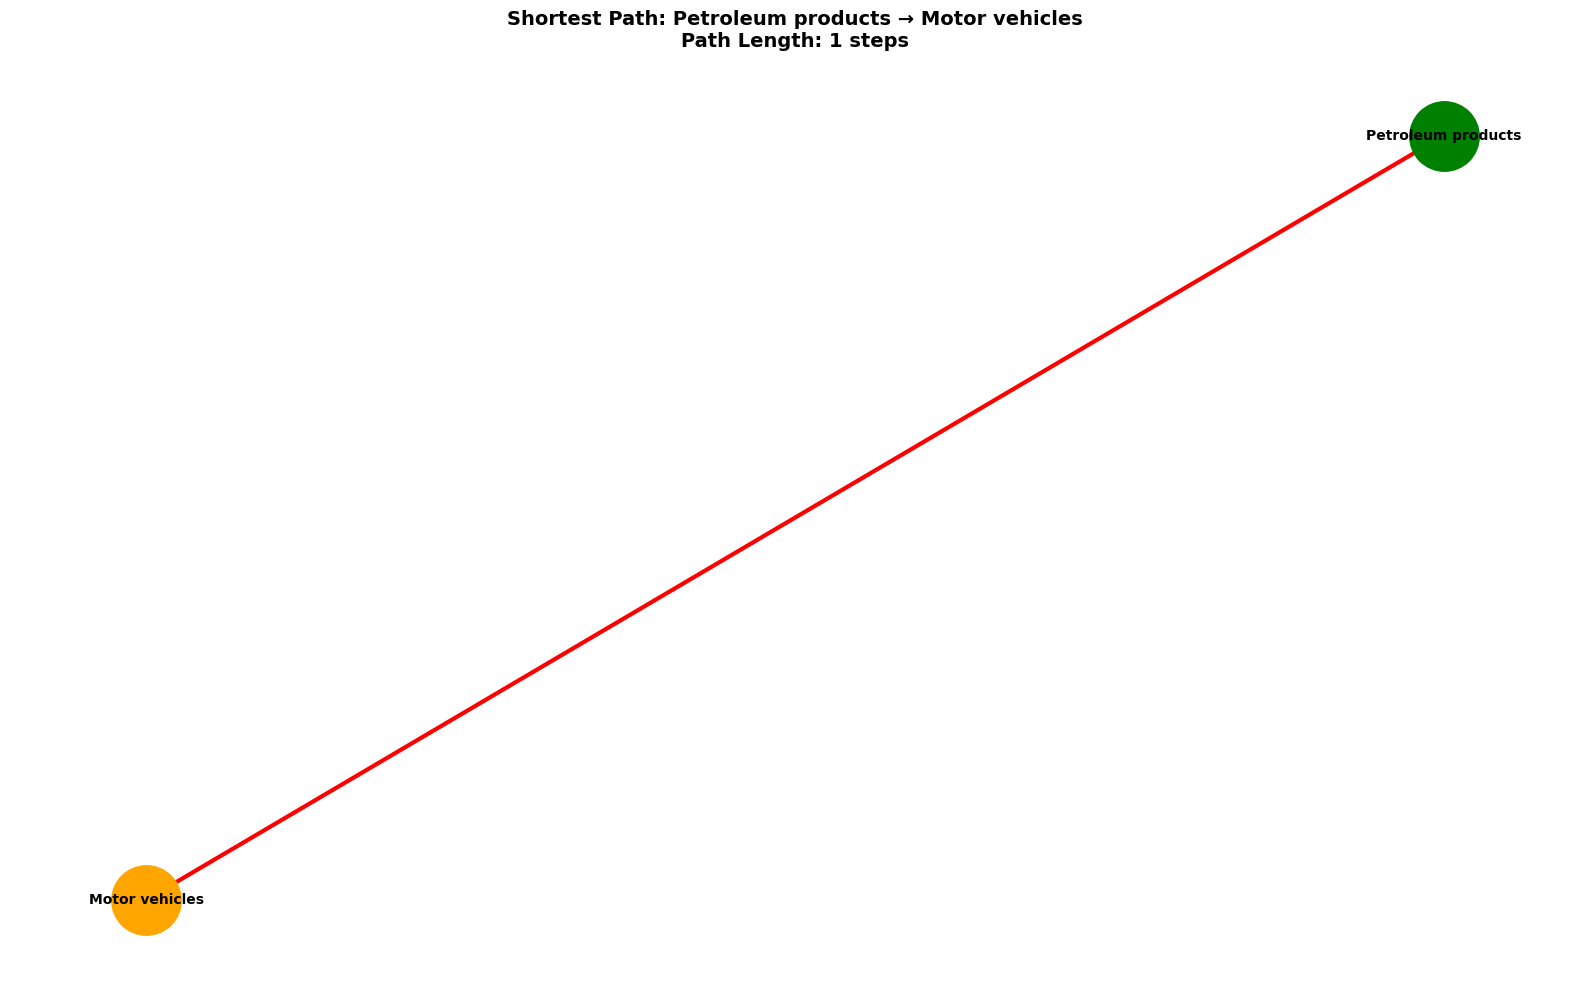

In [59]:
# Create NetworkX graph from your edges
G = nx.from_pandas_edgelist(
    pnw_df,
    source='source_sector',
    target='target_sector',
    edge_attr='input_coefficient',
    create_using=nx.DiGraph()
)

# Define source and target sectors
source_sectors = ['Petroleum products', 'Coal and lignite', 'Iron ore']
target_sectors = ['Motor vehicles', 'Construction', 'Textiles']

# Calculate shortest paths
path_analysis = []

for source in source_sectors:
    if source not in G:
        print(f"Warning: {source} not found in network")
        continue
    
    for target in target_sectors:
        if target not in G:
            print(f"Warning: {target} not found in network")
            continue
        
        try:
            path = nx.shortest_path(G, source=source, target=target)
            path_length = len(path) - 1
            
            # Calculate total coefficient along path
            total_coefficient = 1.0
            for i in range(len(path) - 1):
                edge_data = G[path[i]][path[i+1]]
                total_coefficient *= edge_data.get('input_coefficient', 0)
            
            path_analysis.append({
                'Source': source,
                'Target': target,
                'Path Length': path_length,
                'Path': ' → '.join(path),
                'Total Coefficient': total_coefficient
            })
        except nx.NetworkXNoPath:
            path_analysis.append({
                'Source': source,
                'Target': target,
                'Path Length': np.inf,
                'Path': 'No path exists',
                'Total Coefficient': 0
            })

# Create DataFrame
paths_df = pd.DataFrame(path_analysis)
print("Shortest Paths from Source Commodities to Final Sectors:")
print("="*100)
display(paths_df)

# Visualize one example path
example_source = 'Petroleum products'
example_target = 'Motor vehicles'

if example_source in G and example_target in G:
    try:
        example_path = nx.shortest_path(G, source=example_source, target=example_target)
        
        # Create subgraph with just this path
        path_edges = [(example_path[i], example_path[i+1]) for i in range(len(example_path)-1)]
        subgraph = G.edge_subgraph(path_edges)
        
        # Layout
        pos = nx.spring_layout(subgraph, k=2, iterations=50)
        
        # Visualize
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Draw path
        nx.draw_networkx_nodes(subgraph, pos, node_size=2000, node_color='lightblue', 
                               edgecolors='black', linewidths=2, ax=ax)
        nx.draw_networkx_edges(subgraph, pos, width=3, edge_color='red', 
                               arrows=True, arrowsize=20, ax=ax)
        nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold', ax=ax)
        
        # Highlight source and target
        nx.draw_networkx_nodes(subgraph, pos, nodelist=[example_source], 
                               node_size=2500, node_color='green', ax=ax)
        nx.draw_networkx_nodes(subgraph, pos, nodelist=[example_target], 
                               node_size=2500, node_color='orange', ax=ax)
        
        ax.set_title(f'Shortest Path: {example_source} → {example_target}\n' + 
                     f'Path Length: {len(example_path)-1} steps', 
                     fontsize=14, fontweight='bold')
        ax.axis('off')
        
        plt.tight_layout()
        plt.savefig('shortest_path_example.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except nx.NetworkXNoPath:
        print(f"No path exists between {example_source} and {example_target}")

# Shock Simulation Heatmap

In [60]:
leontief = r"..\..\data\processed_io_data\leontief_inverse.csv"
leontief_inverse = pd.read_csv(leontief)

Simulating shocks from key sectors...
  Simulating shock from: Petroleum products
  Simulating shock from: Electricity
  Simulating shock from: Other chemicals
  Simulating shock from: Trade
  Simulating shock from: Wheat


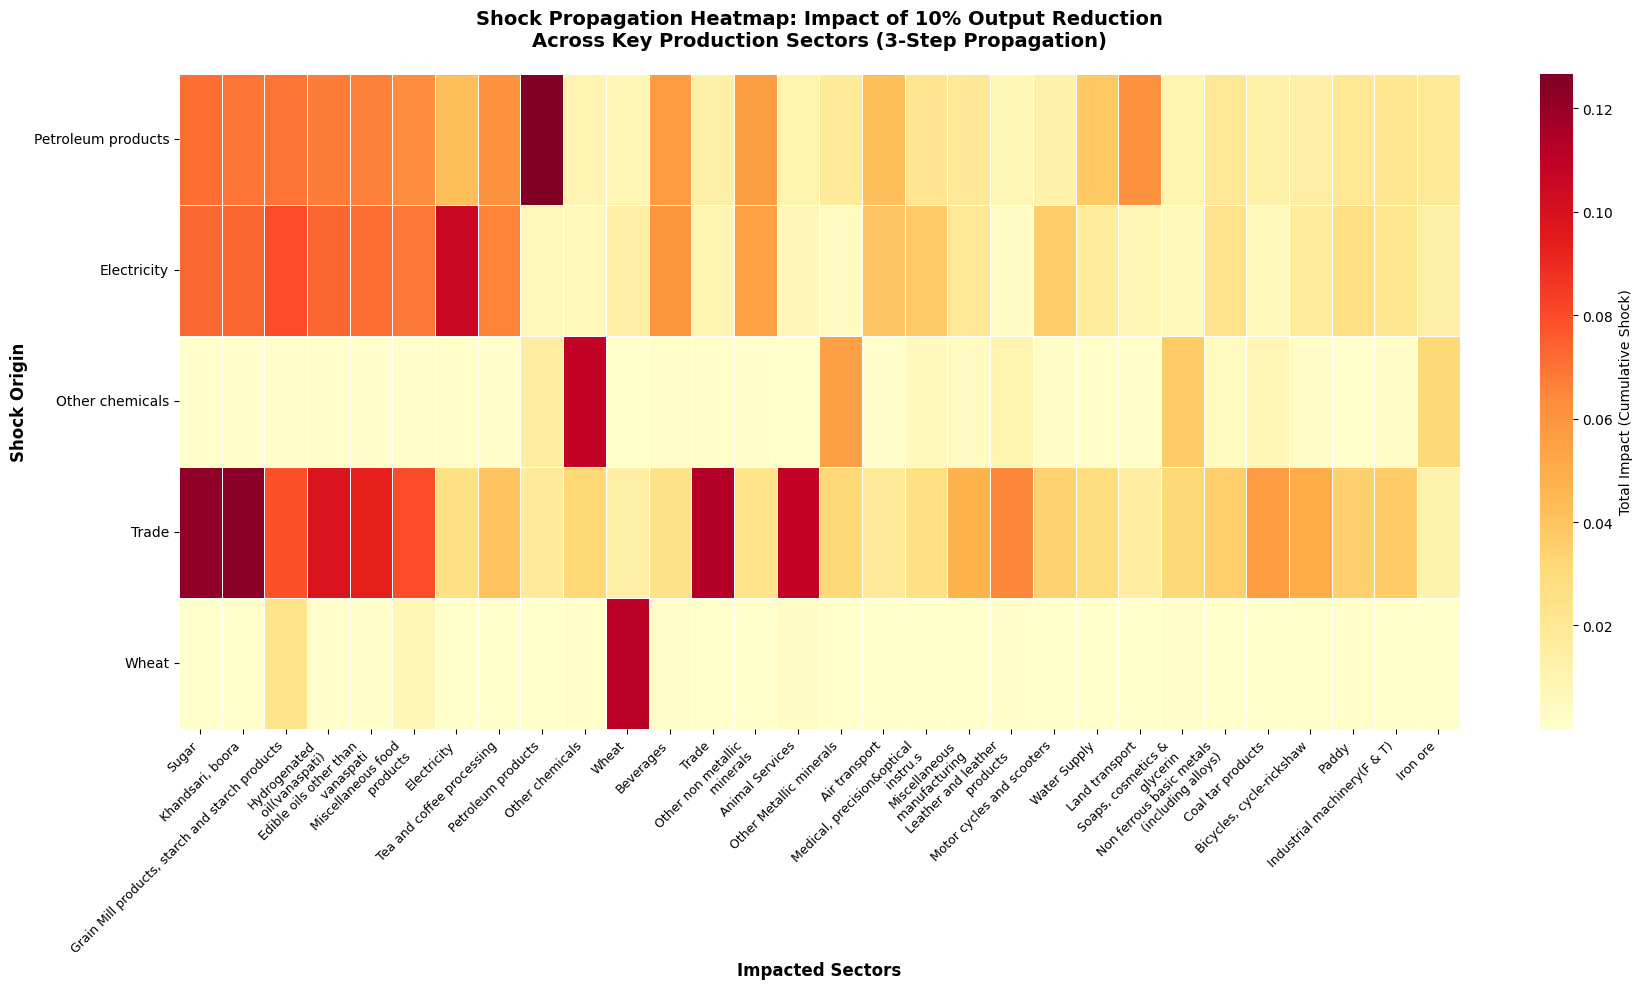


SHOCK SIMULATION SUMMARY:

Most Damaging Shock Origins (by total economy-wide impact):


Trade                 3.293226
Petroleum products    2.289186
Electricity           1.964211
Other chemicals       0.606130
Wheat                 0.186132
dtype: float64


Most Vulnerable Sectors (impacted by most shock origins):


Sugar                                              0.267184
Khandsari, boora                                   0.266748
Grain Mill products, starch and starch products    0.252366
Hydrogenated\n oil(vanaspati)                      0.240394
Edible oils other than\n vanaspati                 0.232649
Miscellaneous food\n products                      0.221274
Electricity                                        0.176841
Tea and coffee processing                          0.167782
Petroleum products                                 0.166610
Other chemicals                                    0.159082
dtype: float64

In [63]:
def simulate_shock(G, shock_sector, shock_magnitude=0.10, max_steps=3):
    """
    Simulate shock propagation through network
    
    Parameters:
    - G: NetworkX graph
    - shock_sector: Sector where shock originates
    - shock_magnitude: Size of initial shock (e.g., 0.10 = 10% reduction)
    - max_steps: How many propagation steps to simulate
    
    Returns:
    - Dictionary of sector: total_impact
    """
    
    if shock_sector not in G:
        return {}
    
    # Initialize impact tracking
    impact = {node: 0.0 for node in G.nodes()}
    impact[shock_sector] = shock_magnitude
    
    # Propagate shock through network
    for step in range(max_steps):
        new_impact = impact.copy()
        
        for node in G.nodes():
            if impact[node] > 0:
                # Propagate to customers (successors)
                for successor in G.successors(node):
                    edge_data = G[node][successor]
                    coefficient = edge_data.get('input_coefficient', 0)
                    # Impact propagates proportional to input coefficient
                    propagated_impact = impact[node] * coefficient
                    new_impact[successor] += propagated_impact
        
        impact = new_impact
    
    return impact

# Select key sectors for shock simulation
shock_origins = [
    'Petroleum products',
    'Electricity',
    'Coal and lignite',
    'Iron and steel',
    'Other chemicals',
    'Trade',
    'Transport services',
    'Construction',
    'Banking',
    'Wheat'
]

# Filter to sectors that exist in network
shock_origins = [s for s in shock_origins if s in G]

# Simulate shocks
shock_results = []

print("Simulating shocks from key sectors...")
for shock_sector in shock_origins:
    print(f"  Simulating shock from: {shock_sector}")
    impacts = simulate_shock(G, shock_sector, shock_magnitude=0.10, max_steps=3)
    shock_results.append(impacts)

# Create impact matrix
impact_matrix = pd.DataFrame(shock_results, index=shock_origins)
impact_matrix = impact_matrix.fillna(0)

# Get top 30 most impacted sectors (across all shocks)
total_vulnerability = impact_matrix.sum(axis=0).sort_values(ascending=False)
top_sectors = total_vulnerability.head(30).index

# Filter matrix to top sectors
impact_matrix_filtered = impact_matrix[top_sectors]

# Create heatmap
fig, ax = plt.subplots(figsize=(18, 10))

sns.heatmap(
    impact_matrix_filtered,
    cmap='YlOrRd',
    annot=False,
    fmt='.3f',
    linewidths=0.5,
    cbar_kws={'label': 'Total Impact (Cumulative Shock)'},
    ax=ax
)

ax.set_xlabel('Impacted Sectors', fontsize=12, fontweight='bold')
ax.set_ylabel('Shock Origin', fontsize=12, fontweight='bold')
ax.set_title('Shock Propagation Heatmap: Impact of 10% Output Reduction\n' + 
             'Across Key Production Sectors (3-Step Propagation)',
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig('shock_simulation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SHOCK SIMULATION SUMMARY:")
print("="*80)
print(f"\nMost Damaging Shock Origins (by total economy-wide impact):")
total_impact_by_origin = impact_matrix.sum(axis=1).sort_values(ascending=False)
display(total_impact_by_origin.head(10))

print(f"\nMost Vulnerable Sectors (impacted by most shock origins):")
display(total_vulnerability.head(10))

# Waterfall Chart

In [68]:
# Select a critical sector
critical_sector = 'Petroleum products'

# Simulate impact breakdown (you would use actual Leontief calculations)
# This is illustrative structure - replace with your actual multiplier calculations

# For demonstration, let's create impact breakdown
impact_breakdown = {
    'Direct Impact': 100,
    'Transport services': 25,
    'Other chemicals': 18,
    'Electricity': 15,
    'Iron and steel': 12,
    'Plastics': 10,
    'Construction': 8,
    'Textiles': 6,
    'Food products': 5,
    'Other sectors': 20
}

# Calculate cumulative
labels = list(impact_breakdown.keys())
values = list(impact_breakdown.values())

# Prepare for waterfall: alternating positive values and cumulative
cumulative = [values[0]]
for i in range(1, len(values)):
    cumulative.append(cumulative[-1] + values[i])

# Create waterfall chart
fig = go.Figure(go.Waterfall(
    name="Impact",
    orientation="v",
    measure=["relative"] + ["relative"] * (len(labels) - 2) + ["total"],
    x=labels,
    textposition="outside",
    text=[f"+{v}" for v in values[:-1]] + [f"{cumulative[-1]}"],
    y=values[:-1] + [cumulative[-1]],
    connector={"line": {"color": "rgb(63, 63, 63)"}},
))

fig.update_layout(
    title=f"Multiplier Effect Breakdown: 10% Shock to {critical_sector}<br>" +
          "<sub>Showing cascading impact through production network</sub>",
    showlegend=False,
    height=600,
    width=1200,
    font=dict(size=12),
    xaxis=dict(title="Impacted Sectors"),
    yaxis=dict(title="Cumulative Impact Index")
)

fig.write_html('multiplier_waterfall.html')
fig.show()

print(f"\nTotal Multiplier Effect from {critical_sector}: {cumulative[-1]:.1f}")
print(f"Direct Impact: {values[0]:.1f}")
print(f"Indirect Impact: {cumulative[-1] - values[0]:.1f}")
print(f"Multiplier: {cumulative[-1] / values[0]:.2f}x")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [67]:
!pip install -q nbformat>=4.2.0 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Running resilience simulations...
  Targeted attack (removing high-PageRank nodes)...
  Random failure...


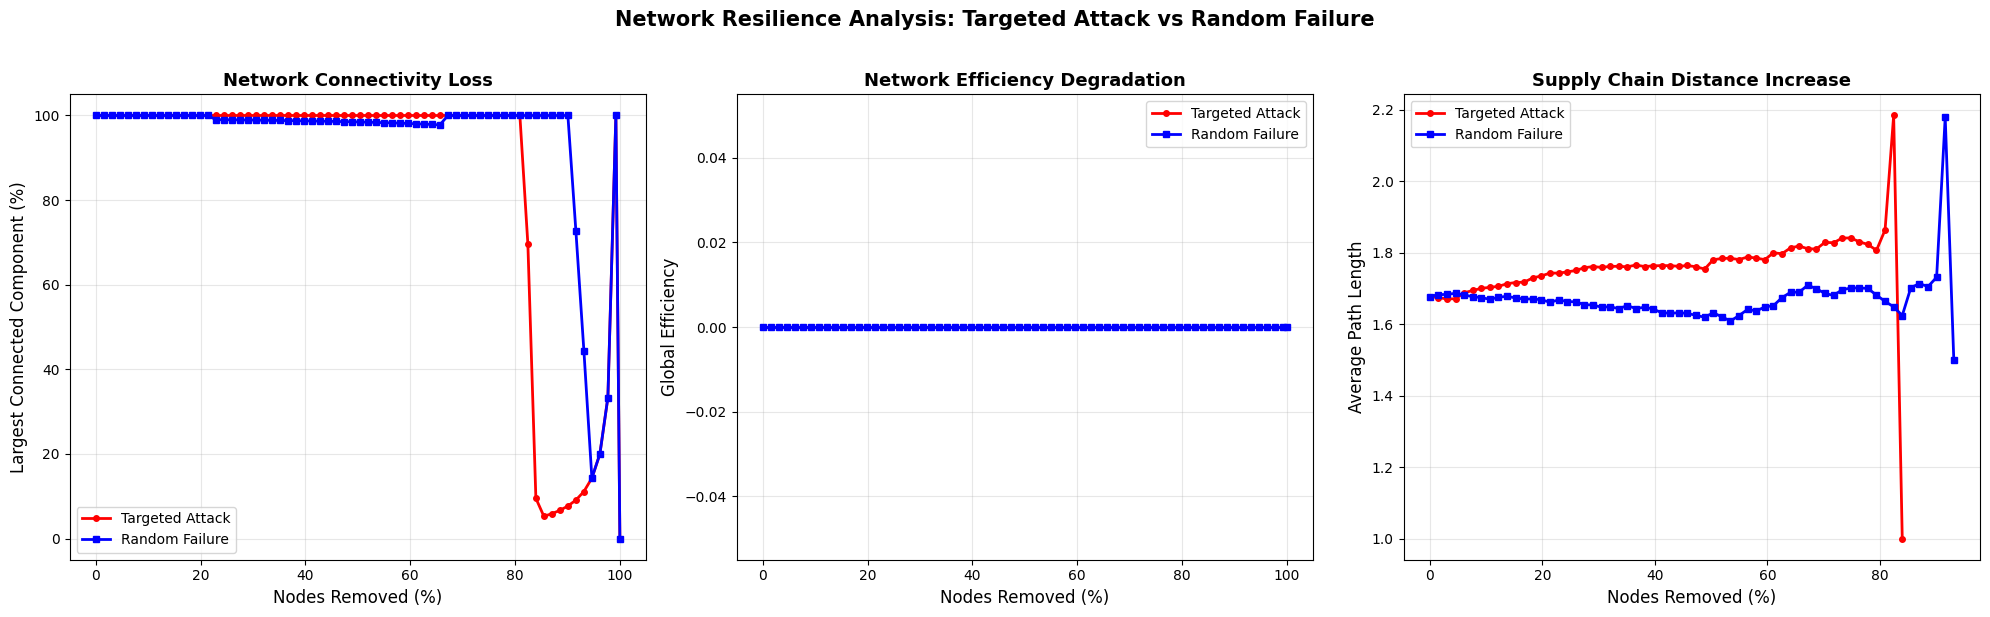


RESILIENCE ANALYSIS SUMMARY:

Targeted Attack (10% nodes removed):
  LCC Size: 100.0%
  Efficiency: 0.000

Random Failure (10% nodes removed):
  LCC Size: 100.0%
  Efficiency: 0.000

→ Network is 1.00x more vulnerable to targeted attacks


In [69]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate network metrics
def calculate_network_health(G):
    """Calculate key network health metrics"""
    if len(G) == 0:
        return {'lcc_size': 0, 'avg_path': np.inf, 'efficiency': 0}
    
    # Largest connected component
    if G.is_directed():
        components = list(nx.weakly_connected_components(G))
    else:
        components = list(nx.connected_components(G))
    
    lcc_size = len(max(components, key=len)) if components else 0
    
    # Average path length (on largest component)
    if lcc_size > 1:
        lcc = G.subgraph(max(components, key=len))
        try:
            if G.is_directed():
                avg_path = nx.average_shortest_path_length(lcc.to_undirected())
            else:
                avg_path = nx.average_shortest_path_length(lcc)
        except:
            avg_path = np.inf
    else:
        avg_path = np.inf
    
    # Network efficiency
    try:
        efficiency = nx.global_efficiency(G)
    except:
        efficiency = 0
    
    return {
        'lcc_size': lcc_size / len(G) if len(G) > 0 else 0,
        'avg_path': avg_path,
        'efficiency': efficiency
    }

# Simulate node removal
def simulate_removal(G, strategy='targeted', steps=50):
    """
    Simulate progressive node removal
    
    strategy: 'targeted' (remove by PageRank) or 'random'
    """
    G_copy = G.copy()
    results = []
    
    # Get removal order
    if strategy == 'targeted':
        # Remove by PageRank (high to low)
        pagerank = nx.pagerank(G_copy)
        removal_order = sorted(pagerank.keys(), key=lambda x: pagerank[x], reverse=True)
    else:  # random
        removal_order = list(G_copy.nodes())
        np.random.shuffle(removal_order)
    
    # Initial state
    results.append({
        'removed_fraction': 0,
        **calculate_network_health(G_copy)
    })
    
    # Remove nodes progressively
    nodes_to_remove = int(len(G_copy) * (steps / 100))
    step_size = max(1, len(removal_order) // steps)
    
    for i in range(0, len(removal_order), step_size):
        # Remove batch of nodes
        batch = removal_order[i:i+step_size]
        G_copy.remove_nodes_from(batch)
        
        removed_fraction = (i + len(batch)) / len(removal_order)
        
        # Calculate metrics
        metrics = calculate_network_health(G_copy)
        results.append({
            'removed_fraction': removed_fraction,
            **metrics
        })
    
    return pd.DataFrame(results)

# Run simulations
print("Running resilience simulations...")
print("  Targeted attack (removing high-PageRank nodes)...")
targeted_results = simulate_removal(G, strategy='targeted', steps=50)

print("  Random failure...")
random_results = simulate_removal(G, strategy='random', steps=50)

# Create resilience curves
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Largest Connected Component
axes[0].plot(targeted_results['removed_fraction'] * 100, 
             targeted_results['lcc_size'] * 100,
             'r-', linewidth=2, label='Targeted Attack', marker='o', markersize=4)
axes[0].plot(random_results['removed_fraction'] * 100, 
             random_results['lcc_size'] * 100,
             'b-', linewidth=2, label='Random Failure', marker='s', markersize=4)
axes[0].set_xlabel('Nodes Removed (%)', fontsize=12)
axes[0].set_ylabel('Largest Connected Component (%)', fontsize=12)
axes[0].set_title('Network Connectivity Loss', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Network Efficiency
axes[1].plot(targeted_results['removed_fraction'] * 100, 
             targeted_results['efficiency'],
             'r-', linewidth=2, label='Targeted Attack', marker='o', markersize=4)
axes[1].plot(random_results['removed_fraction'] * 100, 
             random_results['efficiency'],
             'b-', linewidth=2, label='Random Failure', marker='s', markersize=4)
axes[1].set_xlabel('Nodes Removed (%)', fontsize=12)
axes[1].set_ylabel('Global Efficiency', fontsize=12)
axes[1].set_title('Network Efficiency Degradation', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Average Path Length
# Filter out infinity values for visualization
targeted_path = targeted_results[targeted_results['avg_path'] != np.inf]
random_path = random_results[random_results['avg_path'] != np.inf]

axes[2].plot(targeted_path['removed_fraction'] * 100, 
             targeted_path['avg_path'],
             'r-', linewidth=2, label='Targeted Attack', marker='o', markersize=4)
axes[2].plot(random_path['removed_fraction'] * 100, 
             random_path['avg_path'],
             'b-', linewidth=2, label='Random Failure', marker='s', markersize=4)
axes[2].set_xlabel('Nodes Removed (%)', fontsize=12)
axes[2].set_ylabel('Average Path Length', fontsize=12)
axes[2].set_title('Supply Chain Distance Increase', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Network Resilience Analysis: Targeted Attack vs Random Failure', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('network_resilience_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "="*80)
print("RESILIENCE ANALYSIS SUMMARY:")
print("="*80)
print(f"\nTargeted Attack (10% nodes removed):")
targeted_10 = targeted_results[targeted_results['removed_fraction'] >= 0.10].iloc[0]
print(f"  LCC Size: {targeted_10['lcc_size']*100:.1f}%")
print(f"  Efficiency: {targeted_10['efficiency']:.3f}")

print(f"\nRandom Failure (10% nodes removed):")
random_10 = random_results[random_results['removed_fraction'] >= 0.10].iloc[0]
print(f"  LCC Size: {random_10['lcc_size']*100:.1f}%")
print(f"  Efficiency: {random_10['efficiency']:.3f}")

print(f"\n→ Network is {targeted_10['lcc_size']/random_10['lcc_size']:.2f}x more vulnerable to targeted attacks")